#Reading Data

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Jan  5 08:27:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
######################################
#Import images from Google Drive to Colab
######################################
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
import sys
os.chdir('/content/gdrive/MyDrive/ThesisData')
sys.path.append("/content/gdrive/MyDrive/ThesisData")
!pwd

/content/gdrive/MyDrive/ThesisData


#Import Library

In [6]:
#Import libraries
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Image Preprocessing

In [7]:
# Defime image size
imgWidth = 224
imgHeight = 224

In [8]:
# image preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

base_dir = "../ThesisData"

training_set = train_datagen.flow_from_directory(base_dir+'/train',
                                                 target_size=(imgWidth, imgHeight),
                                                 batch_size=64,
                                                 class_mode='categorical')

valid_set = valid_datagen.flow_from_directory(base_dir+'/val',
                                            target_size=(imgWidth, imgHeight),
                                            batch_size=64,
                                            class_mode='categorical',
                                            shuffle=False)

test_set = test_datagen.flow_from_directory(base_dir+'/test',
                                            target_size=(imgWidth, imgHeight),
                                            batch_size=64,
                                            class_mode='categorical',
                                            shuffle=False)


Found 10024 images belonging to 10 classes.
Found 1253 images belonging to 10 classes.
Found 1253 images belonging to 10 classes.


In [9]:
train_num = training_set.samples
valid_num = valid_set.samples

In [10]:
num_classes = 10
input_shape = (imgHeight, imgWidth , 3)

#VGG16 with CheckPoint

##Train Model

In [11]:
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16

In [ ]:
vgg16Model = VGG16(input_shape=input_shape, weights='imagenet', include_top=False)

In [ ]:
for layer in vgg16Model.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(vgg16Model.output)

prediction = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=vgg16Model.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
  loss='categorical_crossentropy',
  optimizer=opt,
  metrics=["accuracy"]
)

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

annealer = ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('/temp/{epoch}_VGG16.hf5', verbose=1, save_best_only=True, mode='auto', save_freq='epoch')

In [ ]:
import pickle
history = model.fit(
                  training_set,
                  validation_data=valid_set,
                  epochs=20,
                  batch_size=128,
                  callbacks=[annealer, checkpoint],
                  steps_per_epoch=len(training_set),
                  validation_steps=len(valid_set)
                )

#saving model
model.save("VGG16CheckPt_Model.hdf5")


# Save the training history to a file using pickle
with open('VGG16CheckPt_History.pkl', 'wb') as file:
    pickle.dump(history.history, file)

Epoch 1/20
157/157 [==============================] - ETA: 0s - loss: 1.3009 - accuracy: 0.5710
Epoch 1: val_loss improved from inf to 0.61187, saving model to /temp/1_VGG16.hf5
157/157 [==============================] - 228s 1s/step - loss: 1.3009 - accuracy: 0.5710 - val_loss: 0.6119 - val_accuracy: 0.8396 - lr: 0.0010
Epoch 2/20
157/157 [==============================] - ETA: 0s - loss: 0.6834 - accuracy: 0.7911
Epoch 2: val_loss improved from 0.61187 to 0.37407, saving model to /temp/2_VGG16.hf5
157/157 [==============================] - 204s 1s/step - loss: 0.6834 - accuracy: 0.7911 - val_loss: 0.3741 - val_accuracy: 0.9218 - lr: 0.0010
Epoch 3/20
157/157 [==============================] - ETA: 0s - loss: 0.5145 - accuracy: 0.8537
Epoch 3: val_loss improved from 0.37407 to 0.32590, saving model to /temp/3_VGG16.hf5
157/157 [==============================] - 199s 1s/step - loss: 0.5145 - accuracy: 0.8537 - val_loss: 0.3259 - val_accuracy: 0.9170 - lr: 0.0010
Epoch 4/20
157/157 [===

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##Print Metrics

In [3]:
from keras.models import load_model

#Load model from a saved model file
model = load_model('/content/gdrive/MyDrive/ThesisData/VGG16CheckPt_Model.hdf5')

In [ ]:
from time import time
start = time()
evl = model.evaluate(test_set)
test_time = time() - start

test_loss, test_acc = evl[0]*100, evl[1]*100

msg = f'Test Accuracy = {test_acc:5.2f} %'
msg1 = f'Test Loss = {test_loss:5.2f} %'
msg2 = f'Test Time = {test_time:5.2f} s'
print(msg)
print(msg1)
print(msg2)

20/20 [==============================] - 870s 46s/step - loss: 0.2013 - accuracy: 0.9681
Test Accuracy = 96.81 %
Test Loss = 20.13 %
Test Time = 921.61 s


In [ ]:
from sklearn.metrics import classification_report
# Make predictions on the test set
predicted_labels = model.predict(test_set)
# Convert predicted probabilities to class labels (if necessary)
predicted_classes = np.argmax(predicted_labels, axis=1)

# Calculate classification report
report = classification_report(test_set.labels, predicted_classes)
print(report)

20/20 [==============================] - 8s 418ms/step
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       132
           1       0.99      0.96      0.98       124
           2       0.99      0.94      0.96       124
           3       0.98      0.98      0.98       125
           4       0.94      0.95      0.95       124
           5       0.98      0.99      0.99       125
           6       0.98      0.97      0.97       124
           7       0.95      0.97      0.96       126
           8       0.97      0.98      0.98       124
           9       0.94      0.96      0.95       125

    accuracy                           0.97      1253
   macro avg       0.97      0.97      0.97      1253
weighted avg       0.97      0.97      0.97      1253



In [ ]:
# Access the mean accuracy and loss of training from the history object
average_accuracy = np.average(history.history['accuracy'])
average_loss = np.average(history.history['loss'])

print("Training - Average Accuracy:", average_accuracy)
print("Training - Average Loss:", average_loss)

# Access the average accuracy and loss of validation from the history object
average_accuracyVal = np.average(history.history['val_accuracy'])
average_lossVal = np.average(history.history['val_loss'])

print("Validation - Average Accuracy:", average_accuracyVal)
print("Validation - Average Loss:", average_lossVal)

Training - Average Accuracy: 0.9049930185079574
Training - Average Loss: 0.32297363355755804
Validation - Average Accuracy: 0.9484836369752884
Validation - Average Loss: 0.22718306183815


##Visualising Training Progress

Training accuracy: [0.571029543876648, 0.791101336479187, 0.853651225566864, 0.8809856176376343, 0.903232216835022, 0.9088188409805298, 0.9213886857032776, 0.9255785942077637, 0.9276735782623291, 0.9379489421844482, 0.9410415291786194, 0.9354549050331116, 0.9436352849006653, 0.950419008731842, 0.9412410259246826, 0.9471269249916077, 0.9522146582603455, 0.9543096423149109, 0.9568036794662476, 0.9562051296234131]
Validation accuracy: [0.83958500623703, 0.9217877388000488, 0.9169992208480835, 0.9361532330513, 0.9249800443649292, 0.9529129862785339, 0.9529129862785339, 0.9537110924720764, 0.9608938694000244, 0.9569034576416016, 0.9497206807136536, 0.9640861749649048, 0.9704708456993103, 0.9672785401344299, 0.9600957632064819, 0.9664804339408875, 0.9656823873519897, 0.9704708456993103, 0.9680765867233276, 0.9704708456993103]
Training loss: [1.3009402751922607, 0.6833718419075012, 0.5145493745803833, 0.42338934540748596, 0.35899388790130615, 0.3270368278026581, 0.28514373302459717, 0.2717421

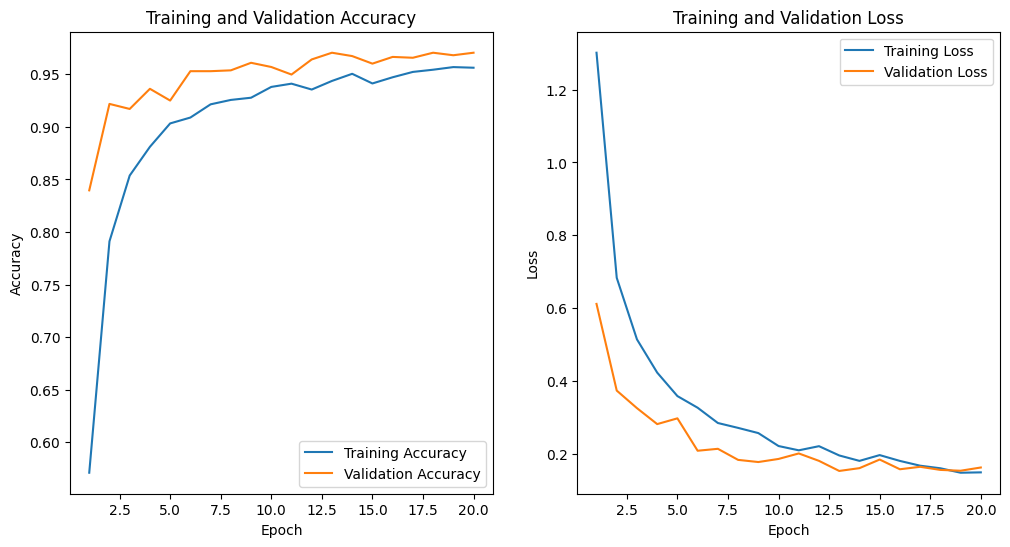

In [ ]:
################################
# Visualize the loss and accuracy
###############################
#accuracy and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print("Training accuracy:", acc)
print("Validation accuracy:", val_acc)

#loss accuracy and validation loss accuracy
loss = history.history['loss']
val_loss = history.history['val_loss']
print("Training loss:", loss)
print("Validation loss:", val_loss)

epochs = range(1, len(loss) + 1)

#Plot Training Accuracy and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

#Plot Training Loss and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('VGG16CheckPt_History.png')
plt.show()

In [12]:
import numpy as np

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

True :  [0 0 0 ... 9 9 9]
20/20 [==============================] - 388s 20s/step
Predicted :  [6 0 0 ... 9 9 9]


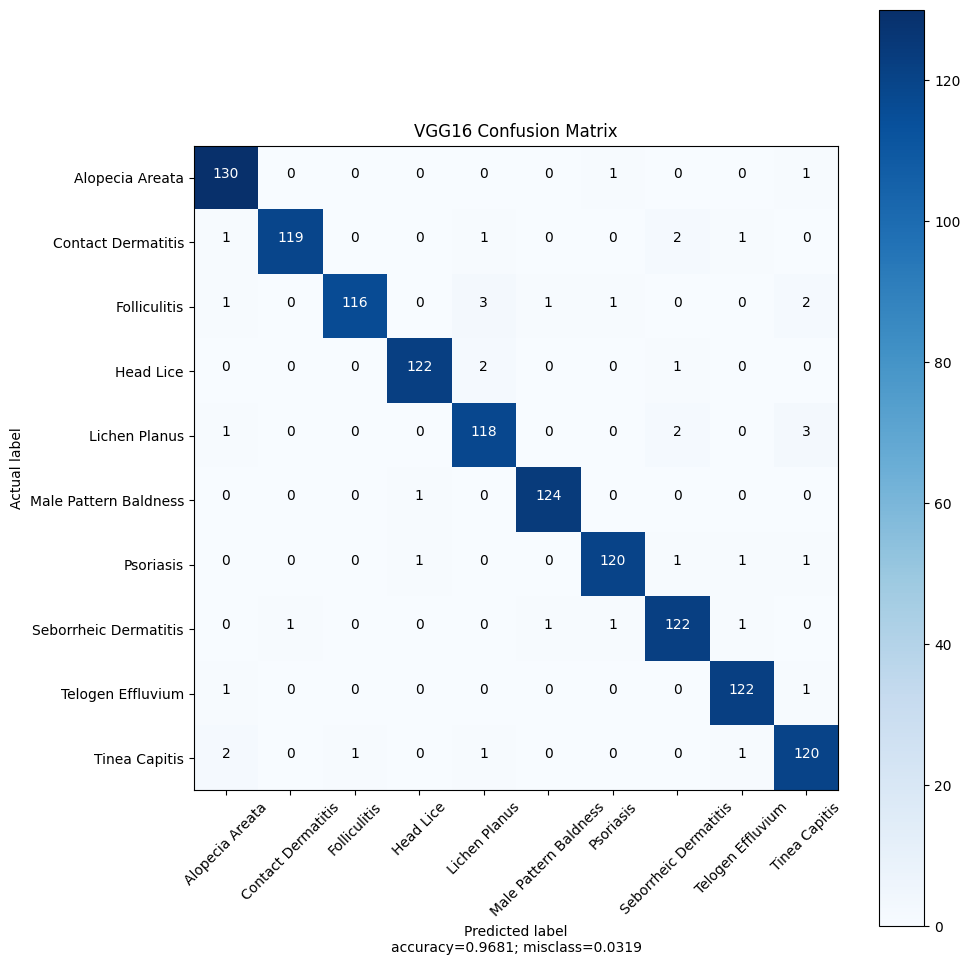

In [13]:
from sklearn.metrics import confusion_matrix

classes = ['Alopecia Areata', 'Contact Dermatitis', 'Folliculitis', 'Head Lice', 'Lichen Planus', 'Male Pattern Baldness', 'Psoriasis', 'Seborrheic Dermatitis', 'Telogen Effluvium', 'Tinea Capitis']

y_true = np.array(test_set.labels)
print("True : ", y_true)

y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
print("Predicted : ", y_pred)

conf_mat = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(cm           = conf_mat,
                      normalize    = False,
                      target_names = classes,
                      title        = "VGG16 Confusion Matrix")

#VGG19 with CheckPoint

##Train Model

In [ ]:
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19

In [ ]:
vgg19Model = VGG19(input_shape=input_shape, weights='imagenet', include_top=False)

for layer in vgg19Model.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(vgg19Model.output)

prediction = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=vgg19Model.input, outputs=prediction)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
  loss='categorical_crossentropy',
  optimizer=opt,
  metrics=["accuracy"]
)

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

annealer = ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('/temp/{epoch}_VGG19.h5', verbose=1, save_best_only=True, mode='auto', save_freq='epoch')

In [ ]:
import pickle
history = model.fit(
                  training_set,
                  validation_data=valid_set,
                  epochs=20,
                  batch_size=128,
                  callbacks=[annealer, checkpoint],
                  steps_per_epoch=len(training_set),
                  validation_steps=len(valid_set)
                )

#saving model
model.save("VGG19CheckPt_Model.hdf5")

# Save the training history to a file using pickle
with open('VGG19CheckPt_History.pkl', 'wb') as file:
    pickle.dump(history.history, file)

Epoch 1/20
157/157 [==============================] - ETA: 0s - loss: 1.3885 - accuracy: 0.5392
Epoch 1: val_loss improved from inf to 0.78847, saving model to /temp/1_VGG19.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


157/157 [==============================] - 252s 2s/step - loss: 1.3885 - accuracy: 0.5392 - val_loss: 0.7885 - val_accuracy: 0.7694 - lr: 0.0010
Epoch 2/20
157/157 [==============================] - ETA: 0s - loss: 0.8143 - accuracy: 0.7440
Epoch 2: val_loss improved from 0.78847 to 0.49764, saving model to /temp/2_VGG19.h5
157/157 [==============================] - 194s 1s/step - loss: 0.8143 - accuracy: 0.7440 - val_loss: 0.4976 - val_accuracy: 0.8627 - lr: 0.0010
Epoch 3/20
157/157 [==============================] - ETA: 0s - loss: 0.6591 - accuracy: 0.7988
Epoch 3: val_loss improved from 0.49764 to 0.41653, saving model to /temp/3_VGG19.h5
157/157 [==============================] - 187s 1s/step - loss: 0.6591 - accuracy: 0.7988 - val_loss: 0.4165 - val_accuracy: 0.8883 - lr: 0.0010
Epoch 4/20
157/157 [==============================] - ETA: 0s - loss: 0.5289 - accuracy: 0.8410
Epoch 4: val_loss improved from 0.41653 to 0.35476, saving model to /temp/4_VGG19.h5
157/157 [=============

##Print Metrics

In [ ]:
# from keras.models import load_model

# #Load model from a saved model file
# model = load_model('/content/gdrive/MyDrive/ThesisData/VGG19CheckPt_Model.hdf5')

In [ ]:
from time import time
start = time()
evl = model.evaluate(test_set)
test_time = time() - start

test_loss, test_acc = evl[0]*100, evl[1]*100

msg = f'Test Accuracy = {test_acc:5.2f} %'
msg1 = f'Test Loss = {test_loss:5.2f} %'
msg2 = f'Test Time = {test_time:5.2f} s'
print(msg)
print(msg1)
print(msg2)

20/20 [==============================] - 7s 342ms/step - loss: 0.1994 - accuracy: 0.9673
Test Accuracy = 96.73 %
Test Loss = 19.94 %
Test Time =  7.55 s


In [ ]:
from sklearn.metrics import classification_report
# Make predictions on the test set
predicted_labels = model.predict(test_set)
# Convert predicted probabilities to class labels (if necessary)
predicted_classes = np.argmax(predicted_labels, axis=1)

# Calculate classification report
report = classification_report(test_set.labels, predicted_classes)
print(report)

20/20 [==============================] - 8s 402ms/step
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       132
           1       0.99      0.96      0.98       124
           2       1.00      0.96      0.98       124
           3       0.92      1.00      0.96       125
           4       0.95      0.97      0.96       124
           5       0.98      0.99      0.99       125
           6       0.99      0.97      0.98       124
           7       0.98      0.95      0.96       126
           8       0.97      0.99      0.98       124
           9       0.97      0.91      0.94       125

    accuracy                           0.97      1253
   macro avg       0.97      0.97      0.97      1253
weighted avg       0.97      0.97      0.97      1253



In [ ]:
# Access the mean accuracy and loss of training from the history object
average_accuracy = np.average(history.history['accuracy'])
average_loss = np.average(history.history['loss'])

print("Training - Average Accuracy:", average_accuracy)
print("Training - Average Loss:", average_loss)

# Access the average accuracy and loss of validation from the history object
average_accuracyVal = np.average(history.history['val_accuracy'])
average_lossVal = np.average(history.history['val_loss'])

print("Validation - Average Accuracy:", average_accuracyVal)
print("Validation - Average Loss:", average_lossVal)

Training - Average Accuracy: 0.8757382303476333
Training - Average Loss: 0.4056628458201885
Validation - Average Accuracy: 0.9272146821022034
Validation - Average Loss: 0.295531365275383


##Visualising Training Progress

Training accuracy: [0.5392059087753296, 0.7440143823623657, 0.7987829446792603, 0.840981662273407, 0.854948103427887, 0.8722066879272461, 0.8836791515350342, 0.9049281477928162, 0.9073224067687988, 0.9160016179084778, 0.9132083058357239, 0.9217877388000488, 0.9098164439201355, 0.9194931983947754, 0.9244812726974487, 0.9278730750083923, 0.9322625994682312, 0.9359537363052368, 0.9321628212928772, 0.9356544017791748]
Validation accuracy: [0.7693535685539246, 0.8627294301986694, 0.8882681727409363, 0.9074221849441528, 0.8978451490402222, 0.9241819381713867, 0.9409417510032654, 0.9409417510032654, 0.9449321627616882, 0.9497206807136536, 0.9648842811584473, 0.9457302689552307, 0.9265761971473694, 0.9569034576416016, 0.9600957632064819, 0.9489225745201111, 0.9505187273025513, 0.9561053514480591, 0.9505187273025513, 0.9577015042304993]
Training loss: [1.3884631395339966, 0.8143356442451477, 0.6591101884841919, 0.528874933719635, 0.48140284419059753, 0.43636634945869446, 0.38904431462287903, 0.

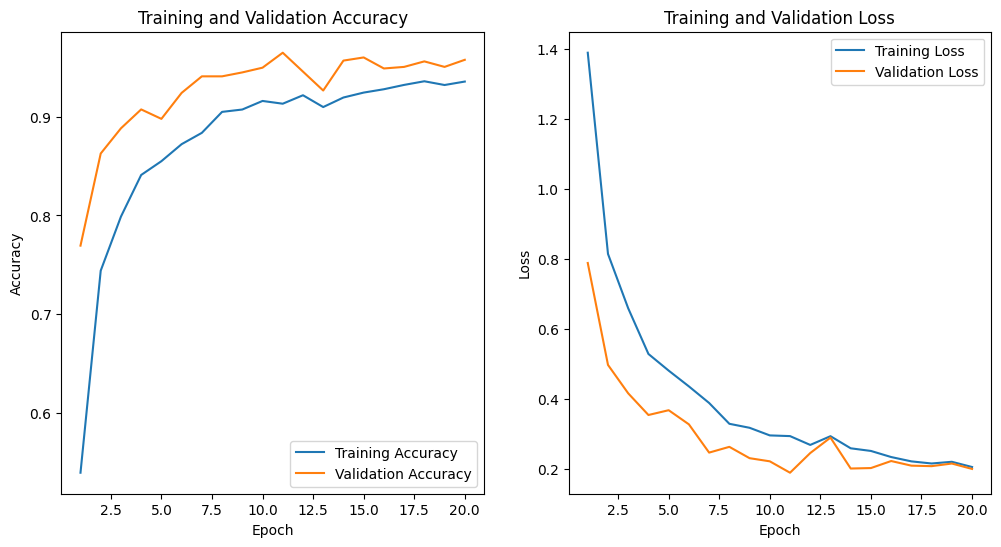

In [ ]:
################################
# Visualize the loss and accuracy
###############################
#accuracy and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print("Training accuracy:", acc)
print("Validation accuracy:", val_acc)

#loss accuracy and validation loss accuracy
loss = history.history['loss']
val_loss = history.history['val_loss']
print("Training loss:", loss)
print("Validation loss:", val_loss)

epochs = range(1, len(loss) + 1)

#Plot Training Accuracy and Validation Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

#Plot Training Loss and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('VGG19CheckPt_History.png')
plt.show()

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

True :  [0 0 0 ... 9 9 9]
20/20 [==============================] - 7s 337ms/step
Predicted :  [8 0 0 ... 9 9 9]


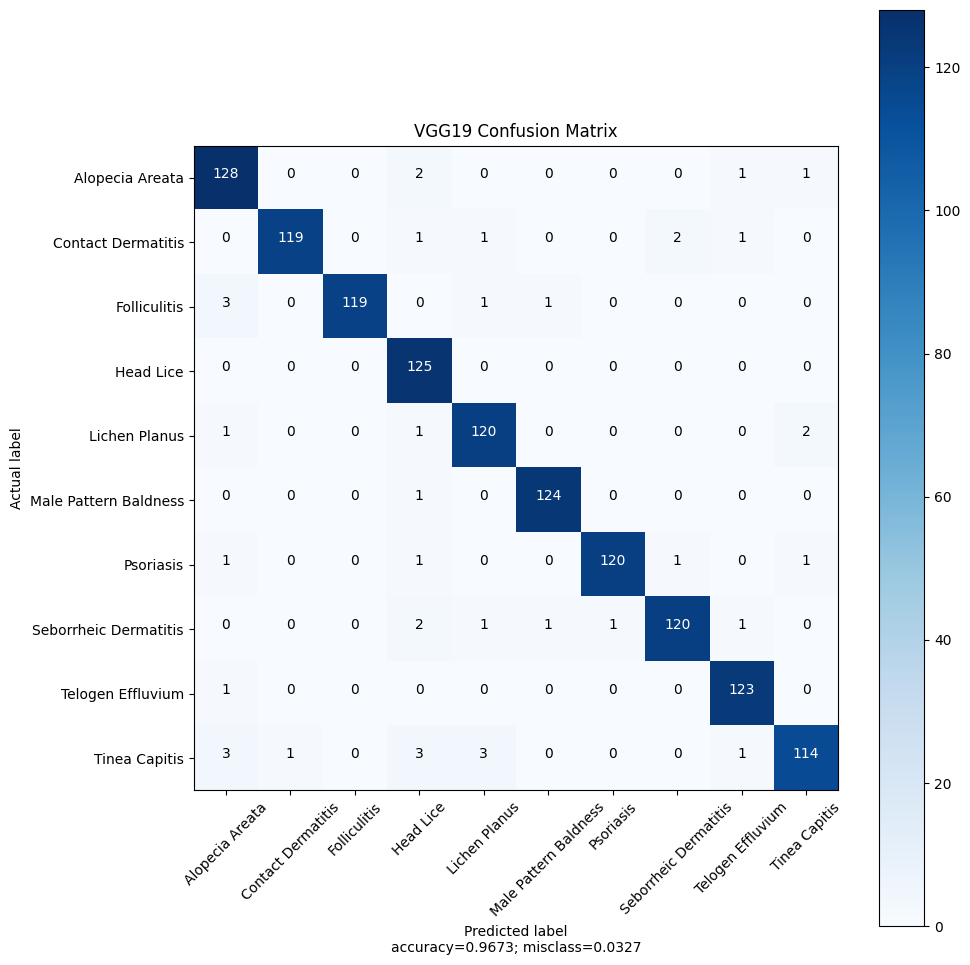

In [ ]:
from sklearn.metrics import confusion_matrix

classes = ['Alopecia Areata', 'Contact Dermatitis', 'Folliculitis', 'Head Lice', 'Lichen Planus', 'Male Pattern Baldness', 'Psoriasis', 'Seborrheic Dermatitis', 'Telogen Effluvium', 'Tinea Capitis']

y_true = np.array(test_set.labels)
print("True : ", y_true)

y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
print("Predicted : ", y_pred)

conf_mat = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(cm           = conf_mat,
                      normalize    = False,
                      target_names = classes,
                      title        = "VGG19 Confusion Matrix")